In [53]:
from cell_paint_seg.utils import get_id_to_path, get_id_from_name_96
from cell_paint_seg.image_io import read_ims

from tqdm import tqdm
from skimage import io, exposure, filters, measure, segmentation
import matplotlib.pyplot as plt
import numpy as np
import napari
import random
import os

In [54]:
channels = ["ER", "DNA", "Mito", "Actin", "RNA", "Golgi/membrane"]

dir_all = "/Users/thomasathey/Documents/shavit-lab/fraenkel/96_well/exp2/Experiment2_DB_Zprojection_unmixed"
dir_test = "/Users/thomasathey/Documents/shavit-lab/fraenkel/96_well/exp2/test_set/tifs"

In [55]:
id_to_path = get_id_to_path(path_dir = dir_all, tag=".tif", id_from_name=get_id_from_name_96)


# Sample

In [56]:
# print(random.sample(list(id_to_path.keys()), 3))

test: ['s158', 's160', 's039']

# view

In [57]:
sample = "s039"

id_to_path = get_id_to_path(path_dir = dir_test, tag=".tif", id_from_name=get_id_from_name_96)

ims = read_ims(id_to_path[sample])

ims = [im.astype('float64') for im in ims]
ims = [np.linalg.norm(im, axis=-1) for im in ims]
ims = [im / np.amax(im) for im in ims]
ims = [exposure.equalize_adapthist(im, clip_limit=0.03) for im in ims]

im_rgb = np.stack([ims[3], ims[4], ims[1]], axis=2)

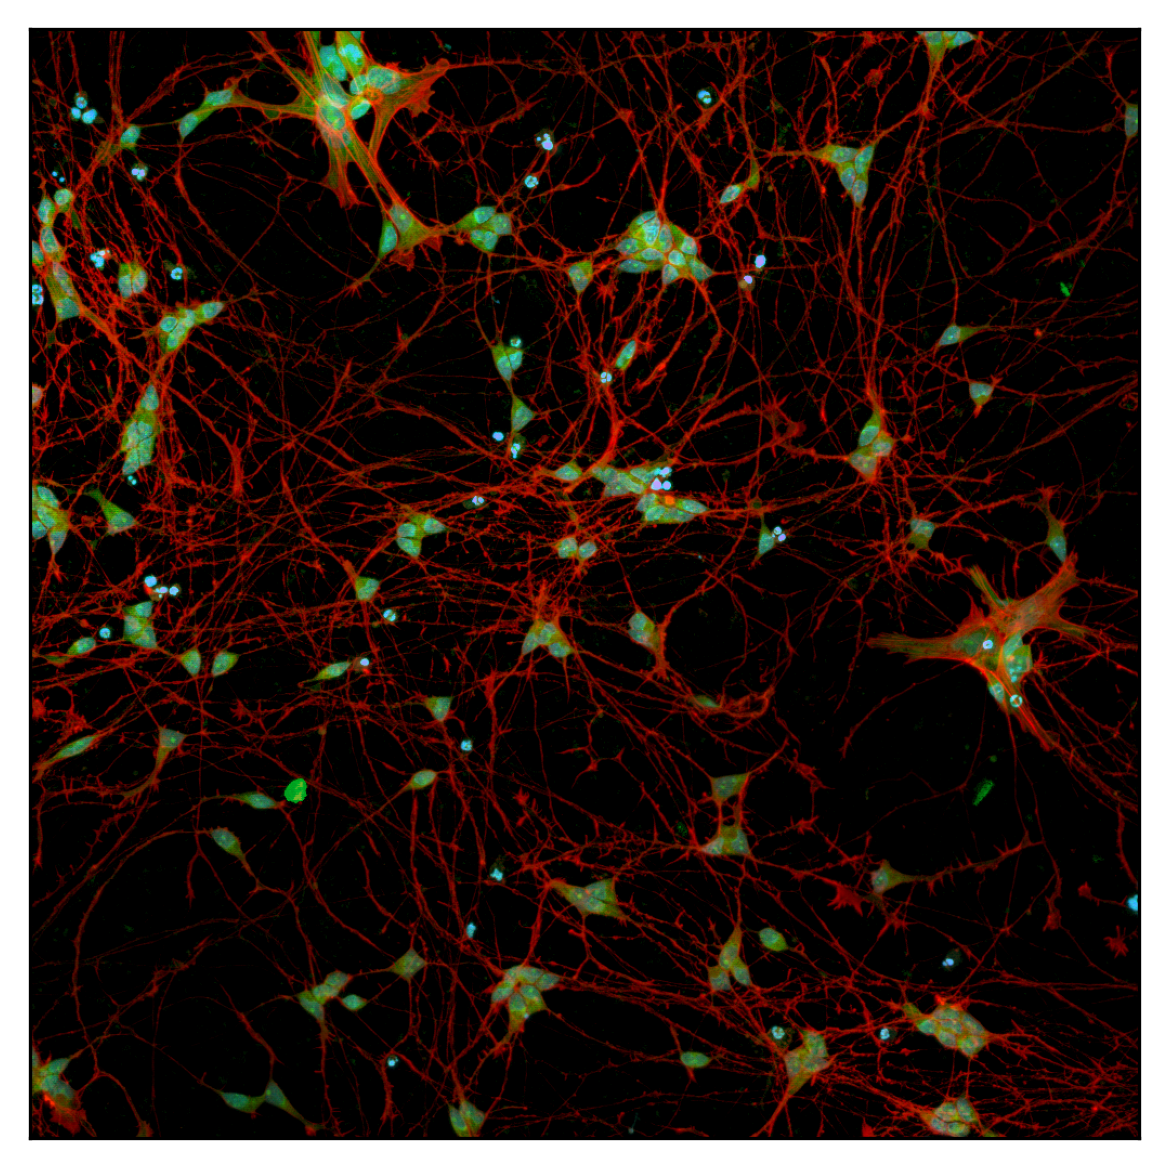

In [58]:
plt.imshow(im_rgb)
plt.gcf().set_dpi(300)
plt.xticks([])
plt.yticks([])
# plt.colorbar()
plt.show()

# napari segmentation

In [140]:
seg_path_nuc = f"/Users/thomasathey/Documents/shavit-lab/fraenkel/96_well/exp2/test_set/seg_gt_v2/{sample}-nuclei.tif"
seg_path_somas = f"/Users/thomasathey/Documents/shavit-lab/fraenkel/96_well/exp2/test_set/seg_gt_v2/{sample}-somas.tif"
seg_path_cells = f"/Users/thomasathey/Documents/shavit-lab/fraenkel/96_well/exp2/test_set/seg_gt_v2/{sample}-cells.tif"

In [141]:
if os.path.exists(seg_path_nuc):
    print(f"nucleus file found: {seg_path_nuc}")
    seg_init_nuc = io.imread(seg_path_nuc)
else:
    threshold = filters.threshold_otsu(ims[1])
    seg_init = ims[1] > threshold
    seg_init = measure.label(seg_init)
    regprops = measure.regionprops(seg_init)

    areas = []
    seg_init_nuc = np.zeros_like(seg_init)
    counter = 1
    for props in regprops:
        if props["area"] >= 64:
            seg_init_nuc[seg_init == props["label"]] = counter
            counter += 1

#soma
if os.path.exists(seg_path_somas):
    print(f"soma file found: {seg_path_somas}")
    seg_init_soma = io.imread(seg_path_somas)
else:
    threshold = filters.threshold_otsu(ims[4])
    seg_init = ims[4] > threshold # RNA channel
    seg_init = np.logical_or(seg_init, seg_init_nuc > 0) # add nucleus 
    seg_init = measure.label(seg_init)
    regprops = measure.regionprops(seg_init)

    areas = []
    mask_init = np.zeros_like(seg_init)
    for props in regprops:
        if props["area"] >= 81:
            mask_init[seg_init == props["label"]] = 1


    seg_init_soma = segmentation.watershed(
        mask_init, markers=seg_init_nuc, mask=mask_init
    )


#soma
if os.path.exists(seg_path_cells):
    print(f"cell file found: {seg_path_cells}")
    seg_init_cells = io.imread(seg_path_cells)
else:
    seg_init_cells = seg_init_soma

nucleus file found: /Users/thomasathey/Documents/shavit-lab/fraenkel/96_well/exp2/test_set/seg_gt_v2/s039-nuclei.tif
soma file found: /Users/thomasathey/Documents/shavit-lab/fraenkel/96_well/exp2/test_set/seg_gt_v2/s039-somas.tif
cell file found: /Users/thomasathey/Documents/shavit-lab/fraenkel/96_well/exp2/test_set/seg_gt_v2/s039-cells.tif


In [142]:
viewer = napari.Viewer()
for im, c in zip(ims, channels):
    viewer.add_image(im, name=c, scale=(0.6, 0.6))


viewer.add_image(im_rgb, name="rgb", rgb=True, scale=(0.6, 0.6))

print(f"max nuc: {np.amax(seg_init_nuc)}, max soma: {np.amax(seg_init_soma)}, max cell: {np.amax(seg_init_cells)}")
viewer.add_labels(seg_init_nuc, name="nuclei", scale=(0.6, 0.6))
viewer.add_labels(seg_init_soma, name="somas", scale=(0.6, 0.6))
viewer.add_labels(seg_init_cells, name="cells", scale=(0.6, 0.6))

viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

max nuc: 211, max soma: 211, max cell: 211


# Clean up labels

In [143]:
from cell_paint_seg.utils import combine_soma_cell_labels_annot

In [151]:
dir_seg = "/Users/thomasathey/Documents/shavit-lab/fraenkel/96_well/exp2/test_set/seg_gt_v2/"

id_to_path_seg = get_id_to_path(dir_seg, tag=".tif", id_from_name=get_id_from_name_96)

for id, paths in id_to_path_seg.items():
    if sample not in id:
        continue
    for path in paths:
        if "nuclei" in str(path):
            seg_nuc = io.imread(path)
        elif "somas" in str(path):
            seg_soma = io.imread(path)
        elif "cells" in str(path):
            seg_cell = io.imread(path)

    print("Separating components...")
    for comp, seg in zip(["Nuc", "Soma", "Cell"], [seg_nuc, seg_soma, seg_cell]):
        new_label = np.amax(seg) + 1
        for label in np.unique(seg):
            # background
            if label == 0: 
                continue

            lbl = measure.label(seg == label)
            if not np.amax(lbl) == 1:
                print(f"{comp} {label} has {np.amax(lbl)} disconnected components - renaming...")
                regprops = measure.regionprops(lbl)
                for props in regprops[1:]:
                    mask = lbl == props["label"]
                    seg[mask] = new_label
                    new_label += 1
                
    
    print("Matching labels...")
    soma_to_nuc = {}
    for nuc_label in tqdm(np.unique(seg_nuc)):
        if nuc_label == 0:
            continue
        found = False
        for soma_label in np.unique(seg_soma):
            if soma_label == 0:
                continue
            recall = np.sum((seg_nuc == nuc_label) & (seg_soma == soma_label)) / np.sum((seg_nuc == nuc_label))
            if recall > 0.9:
                assert soma_label not in soma_to_nuc.keys()
                soma_to_nuc[soma_label] = nuc_label
                found = True
        if not found:
            print(f"nuc {nuc_label} not found in soma")

    seg_soma_relabel = np.zeros_like(seg_soma)
    for soma_label, nuc_label in soma_to_nuc.items():
        seg_soma_relabel[seg_soma == soma_label] = nuc_label
    seg_soma = seg_soma_relabel

    print("Matching labels...")
    cell_to_soma = {}
    for soma_label in tqdm(np.unique(seg_soma)):
        if soma_label == 0:
            continue
        found = False
        for cell_label in np.unique(seg_cell):
            if cell_label == 0:
                continue
            recall = np.sum((seg_soma == soma_label) & (seg_cell == cell_label)) / np.sum((seg_soma == soma_label))
            if recall > 0.9:
                if cell_label in cell_to_soma.keys():
                    print(f"cell {cell_label} already matched to soma {cell_to_soma[cell_label]}")
                #assert cell_label not in cell_to_soma.keys()
                cell_to_soma[cell_label] = soma_label
                found = True
        if not found:
            print(f"soma {soma_label} not found in cells")

    seg_cell_relabel = np.zeros_like(seg_cell)
    for cell_label, soma_label in cell_to_soma.items():
        seg_cell_relabel[seg_cell == cell_label] = soma_label

    print("Subsetting...")
    for label in np.unique(seg_nuc):
        if label == 0:
            continue
        seg_soma[seg_nuc == label] = label
        seg_cell[seg_soma == label] = label

    print("Relabelling consecutively...")
    seg_nuc_relabeled = np.zeros_like(seg_nuc)
    seg_soma_relabeled = np.zeros_like(seg_soma)
    seg_cell_relabeled = np.zeros_like(seg_cell)
    counter = 1
    for label in np.unique(seg_nuc):
        if label == 0:
            continue
        seg_nuc_relabeled[seg_nuc == label] = counter
        seg_soma_relabeled[seg_soma == label] = counter
        seg_cell_relabeled[seg_cell == label] = counter
        counter += 1

    seg_nuc = seg_nuc_relabeled
    seg_soma = seg_soma_relabeled
    seg_cell = seg_cell_relabeled
        

Separating components...
Nuc 199 has 2 disconnected components - renaming...
Soma 172 has 2 disconnected components - renaming...
Soma 199 has 2 disconnected components - renaming...
Cell 172 has 2 disconnected components - renaming...
Cell 199 has 2 disconnected components - renaming...
Matching labels...


100%|██████████| 208/208 [00:39<00:00,  5.20it/s]


Matching labels...


100%|██████████| 208/208 [00:40<00:00,  5.19it/s]


Subsetting...
Relabelling consecutively...


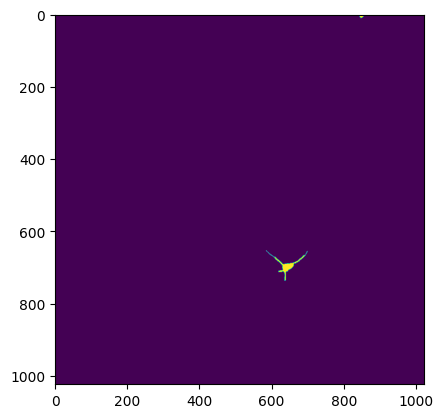

In [146]:
plt.imshow(seg_init_cells == 199)

In [153]:
viewer = napari.Viewer()
for im, c in zip(ims, channels):
    viewer.add_image(im, name=c, scale=(0.6, 0.6))

viewer.add_image(im_rgb, name="rgb", rgb=True, scale=(0.6, 0.6))

print(f"max nuc: {np.amax(seg_nuc)}, max soma: {np.amax(seg_soma)}, max cell: {np.amax(seg_cell)}")
viewer.add_labels(seg_nuc, name="nuclei", scale=(0.6, 0.6))
viewer.add_labels(seg_soma, name="somas", scale=(0.6, 0.6))
viewer.add_labels(seg_cell, name="cells", scale=(0.6, 0.6))

viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

max nuc: 207, max soma: 207, max cell: 207
